# Deep learning project

This project will focus on analyzing Reinforcemnet Learning model behaviour. We will see which action the algorithm choose ,discuss on why these actions are chosen for the given state, and analyze its logic through visualizations.

The environment that we will choose is OpenAI's gym Acrobot environment.
Briefly explain, Acrobot is an environment consist of 2 connected-linear bar which both bar can rotate around its joint freely.

GOAL: reach the height of 1 (which is equal to length of one bar).

OBSERVATION (State): \[$\cos{\theta_1}, \sin{\theta_1}, \cos{\theta_2}, \sin{\theta_2} , \omega_1 , \omega_2$\], which $\omega_1$ and $\omega_2$ are the angular velocity of Acrobot's bars.



Import libraries:

In [16]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from collections import namedtuple
import os
from utils import plotLearning
# from tensorboardX import SummaryWriter
# from datetime import datetime
# import glob, os
# import Box2D

Initialize environment and path variables:

In [2]:
#initialize environment and path variables
env = gym.make("Acrobot-v1")
env.seed(1)
torch.manual_seed(1)
np.random.seed(1)

#     STATE : 
#     [cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2]
#     A state of [1, 0, 1, 0, ..., ...] means that both links point downwards.
    
#     ACTIONs:
#     [+1,0,-1]

Now, we build a function to compute height of the given state.
The original formula from the OpenAI gym's acrobat.py is:

$\qquad - \cos{\theta_1} - \cos{(\theta_1 + \theta_2)}$

But the state we got is in the form of ($\cos{\theta_1}, \sin{\theta_1}, \cos{\theta_2}, \sin{\theta_2} , \omega_1 , \omega_2$), which $\omega_1$ and $\omega_2$ are the angular velocity of both acrobat bars.

Since we don't have $\cos{(\theta_1 + \theta_2)}$, so we need to compute it by using this formula:

$\qquad  \cos{(\theta_1 + \theta_2)} = \cos{\theta_1}\cos{\theta_2} - \sin{\theta_1}\sin{\theta_2}$

Applying the previous formula, we can now calculate the height of the given state like below:

In [3]:
#return height of the given state
def get_height(state):
    cos_a, sin_a, cos_b, sin_b , _ , _ = state
    return -cos_a - (cos_a*cos_b - sin_a*sin_b)

Now, we will look at the performance of a random policy.
We will track the total rewards of each episodes and also the best height it can reach to see how good this policy is.

In [4]:
#random policy
best_episode_height = []
rewards = []
successful_steps = 0
num_episode = 1000

#episodes
for episode in range(1000):
    running_reward = 0
    env.reset()
    max_height = -2
    #steps
    for i in range(200):
        #do random action
        state, reward, done, _ = env.step(np.random.randint(0,3))
        running_reward += reward
        current_height = get_height(state)
        #success steps count
        if current_height>1:
            successful_steps += 1
        #update max_height
        if current_height > max_height:
            max_height = current_height
    rewards.append(running_reward)
    best_episode_height.append(max_height)

The two plots below will show you the best height of each episode and total reward of each episode.

successful steps: 0


Text(0.5, 1.0, 'total reward of each episode')

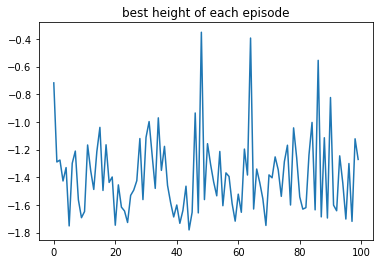

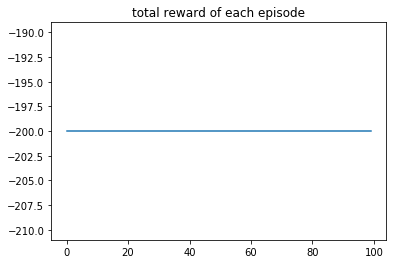

In [5]:
print("successful steps: {}".format(successful_steps))
# plot = plt.plot(best_episode_height)
# plot.x_label("Best height of each episode")
# plt.plot(rewards)
# plt.plot()

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(best_episode_height)
ax.set_title("best height of each episode")

fig2 = plt.figure(figsize=(10,4))
ax = fig2.add_subplot(1,1,1)
ax.plot(rewards)
ax.set_title("total reward of each episode")

From the results shown above, we can see that none of the episodes reach the goal height (height of 1). So, its total rewards are all at -200 since we will get a reward of -1 for each step we took and we have 200 steps per epoch.

Now, we will create a Neural Network model to be used as Q-value approximator for our Q-learning algorithm:

In [6]:
# DQN model
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.state_space = env.observation_space.shape[0] #size of the observation space (state)
        self.action_space = env.action_space.n #number of possible actions
        self.hidden = 100
        #we will only use 2 linear layers here since our environment is quite simple
        self.lin1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.lin2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.lin1,
            self.lin2,
        )
        return model(x)
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

Now, we implement Q-learning algorithm using the neural network architecture we created above:

In [7]:
#set this variable to True to render the training session
visualization = False

# Parameters
steps = 300
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 500
learning_rate = 0.001
successful_episodes = 0

#keep tracking best height of each episode and total rewards of each episode
best_episode_height = []
rewards = []

# Initialize DQN_model
model1 = QNN()
model1.apply(weights_init)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

#close previous environment (in case, we haven't close any environment)
env.close()

#the training starts here
for episode in trange(episodes):
    running_reward = 0
    episode_loss = 0
    episode_reward = 0
    max_height = -2
    state = env.reset()
    
    for s in range(steps):
        # render the environment every 100 episodes when visualization variable is True
        if episode % 100 == 0 and episode > 0 and visualization==True:
           env.render()
        
        # get Q-values of the input state from the model
        Q = model1(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            #choose random action (torque = [-1,0,+1])
            action = np.random.randint(0,3)
        else:
            #choose the best action we get from model
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # get the next state and reward
        state_1, reward, terminal, _ = env.step(action)
        running_reward += reward
        
        # Find max Q of the next state from predicted Q-values of our model
        Q1 = model1(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        model1.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        episode_reward += reward
        
        #compute height of the current step 
        current_height = get_height(state)
        
        #update max_height
        if current_height > max_height:
            max_height = current_height
        
        #reach terminal
        if terminal:
            #height of next state
            next_height = get_height(state_1)
            
            if next_height > max_height:
                max_height = next_height
            
            #if terminal is goal state
            if next_height > 1:
                #success steps count
                successful_episodes += 1

                #reduce epsilon everytime we exceed goal height
                epsilon *= .995

                # Adjust learning rate
                scheduler.step()
            break
        else:
            state = state_1
    
    #record best height of this episode and its reward
    best_episode_height.append(max_height)
    reward_history.append(running_reward)
            
print('successful episodes: {:d} - {:.4f}%'.format(successful_episodes, successful_episodes/episodes*100))

100%|██████████| 500/500 [03:34<00:00,  2.96it/s]


successful episodes: 383 - 76.6000%


In [8]:
env.close()

Now, we will plot the result we got from our model above:

Text(0.5, 1.0, 'total reward of each episode')

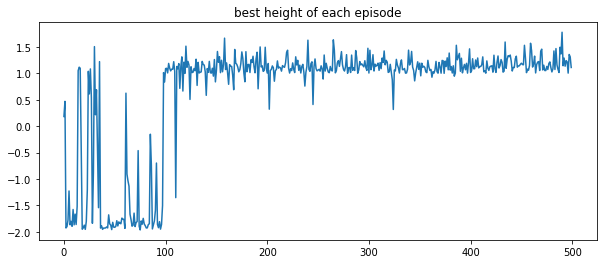

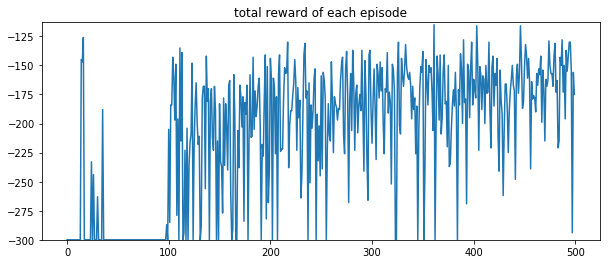

In [9]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(best_episode_height)
ax.set_title("best height of each episode")

fig2 = plt.figure(figsize=(10,4))
ax = fig2.add_subplot(1,1,1)
ax.plot(reward_history)
plt.ylim(-steps,np.max(reward_history)+2)
ax.set_title("total reward of each episode")

We can see that our model can reach the goal at height 1 in a just few episodes of training, but it is very noisy and didn't perform well consistently. The reward plot is also the same. Total rewards jump from zero to a much better performance very fast but it is very noisy.

Now, we can see the performance of our model in realtime by running the cell below:

avg successful steps: 63.8 - 12.7600%
avg first successful step: 173.1 


Text(0.5, 1.0, 'avg_success from 10 sample runs')

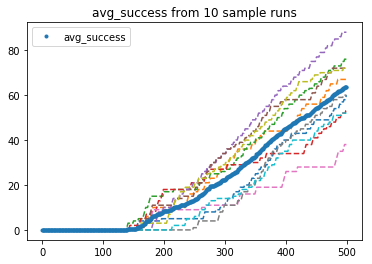

In [10]:
import time
fps = 20
visualization = False

#plot successful steps count
N=10

#setupvariables
model = model1
success_growths = []
first_successful_steps = []
successful_stepss = []

ax.set_title("Successful steps count")

for n in range(N):
    state = env.reset()
    steps = 500
    successful_steps = 0
    first_successful_step = steps
    success_growth = []
    for i in range(steps):
        if visualization==True:
            time.sleep(1/fps)
            env.render()
        Q = model(Variable(torch.from_numpy(state).type(torch.FloatTensor))).detach().numpy()
        action = np.argmax(Q)
        state, reward, done, _ = env.step(action)
        running_reward += reward
        current_height = get_height(state)
        #success steps count
        if current_height>1:
            successful_steps += 1
            if first_successful_step > i:
                first_successful_step=i
        success_growth.append(successful_steps)
    success_growths.append(success_growth)
    first_successful_steps.append(first_successful_step)
    successful_stepss.append(successful_steps)
    
print('avg successful steps: {} - {:.4f}%'.format(np.mean(successful_stepss), np.mean(successful_stepss)/steps*100))
print('avg first successful step: {} '.format(np.mean(first_successful_steps)))
env.close()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
for n in range(N):
    ax.plot(success_growths[n],'--')
ax.plot(np.mean(success_growths, axis=0),'.', label="avg_success")
ax.legend()
ax.set_title("avg_success from {} sample runs".format(N))

Now, we will plot the policy of our trained DQN_model out to analyze its decision and behaviour of each state:

In [11]:
#number of samples we will plot
num = 2000

#random state variables
t1 = np.random.uniform(0, 2*np.pi, num)
t2 = np.random.uniform(0, 2*np.pi, num)
Y1 = np.cos(t1)
X1 = np.sin(t1)
Y2 = np.cos(t2)
X2 = np.sin(t2)

#random angular velocity of each state
S1 = np.random.uniform(-4*np.pi, 4*np.pi, num)
S2 = np.random.uniform(-9*np.pi, 9*np.pi, num)

#Z is our action variables predicted by the model from all random variables above
Z = []
for i in range(len(t1)):
    _, action = torch.max(model1(Variable(torch.from_numpy(np.array([
        Y1[i],X1[i],Y2[i],X2[i],S1[i],S2[i]
        ]))).type(torch.FloatTensor)), dim = -1)
    Z.append(action.item())
#convert to pandas' Series object
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['-1','0','+1']

Let see the relationship between coordinate (X1,Y1) and the chosen action

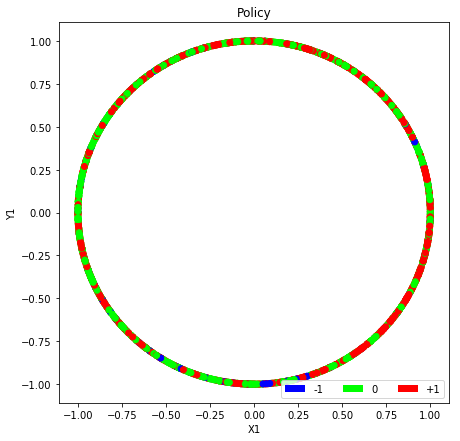

In [12]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,Y1, c=Z)
ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

From the above plot, we don't see much pattern relating coordinate (X1,Y1) to the chosen action.
Now, we will plot the relationship of X1 (first bar x-axis direction), S1 (velocity of first bar), and chosen actions.

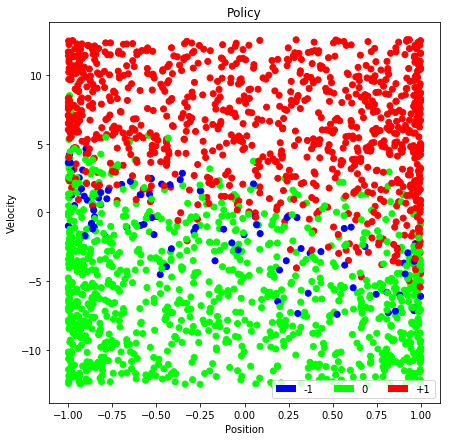

In [13]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,S1, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

# not done ^^^

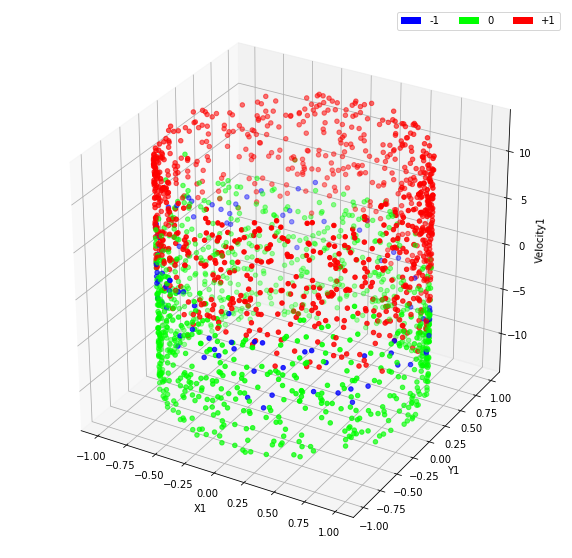

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1, Y1, S1, c=Z, marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_zlabel('Velocity1')
plt.legend(recs,labels,ncol=3)

plt.show()

### Improved Q-learning by modifying rewards

We got an idea from internet that we can help our model learn faster or having a better performance model by modifying the reward function. Since we know that in the Acrobot environment, the higher the manitude of velocity, the faster that it will reach goal state, and that is what we're going to modify to the reward.

We will use the same model as before but we will change 3 things:
- Modify rewards so that it take angular velocity into account (previously it cares only the total height of the Acrobot). The reason of this modification is to encourage the model to increase the magnitude of angular velocity so that it reach goal more efficiently.
- Reduce the number of steps per episode to force the model to learn how to reach goal faster
- Increase number of episodes (model might need more epidsodes to learn how to reach goal when we reduced #steps)

In [61]:
# Parameters
visualization = False
steps = 100        #reduce number of steps per episodes
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000     #increase number of episodes
learning_rate = 0.001
successful_episodes = 0

#plot variables
best_episode_height = []
rewards = []

# Initialize DQN_model
model2 = QNN()
#model2.apply(weights_init)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

#close previous env
env.close()

for episode in trange(episodes):
    running_reward = 0
    episode_loss = 0
    episode_reward = 0
    max_height = -2
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        if episode % 100 == 0 and episode > 0 and visualization==True:
           env.render()
        
        # Get first action value function
        Q = model2(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, terminal, _ = env.step(action)
        
        #modified reward so that it takes normalized angular velocity into account
        reward += (1/steps)*(np.absolute(state_1[4])/(4*np.pi))
        
        running_reward += reward
        
        # Find max Q for t+1 state
        Q1 = model2(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        model2.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        episode_reward += reward
        
        #compute height of the current step 
        current_height = get_height(state)
        #update max_height
        if current_height > max_height:
            max_height = current_height
        
        #reach terminal
        if terminal:
            #height of next state
            next_height = get_height(state_1)
            
            if next_height > max_height:
                max_height = next_height
            
            #if terminal is goal state
            if next_height > 1:
                #success steps count
                successful_episodes += 1

                #reduce epsilon everytime we exceed goal height
                epsilon *= .995

                # Adjust learning rate
                scheduler.step()
            break
        else:
            state = state_1
    
    #record best height of this episode
    best_episode_height.append(max_height)
    reward_history.append(running_reward)
            
print('successful episodes: {:d} - {:.4f}%'.format(successful_episodes, successful_episodes/episodes*100))

  7%|▋         | 71/1000 [00:09<01:59,  7.80it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'total reward of each episode')

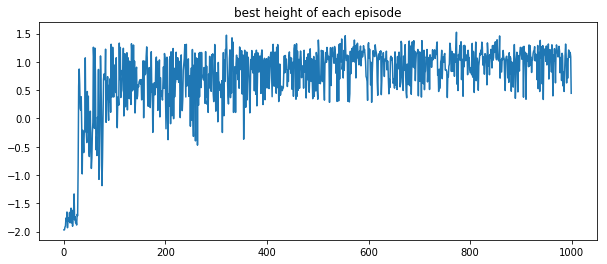

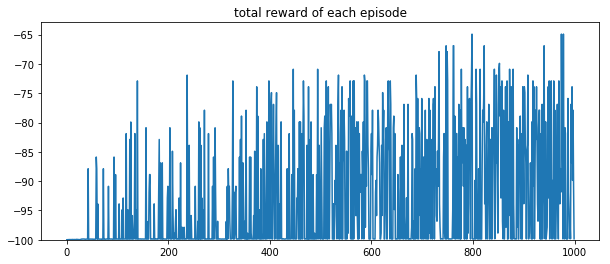

In [16]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(best_episode_height)
ax.set_title("best height of each episode")

fig2 = plt.figure(figsize=(10,4))
ax = fig2.add_subplot(1,1,1)
ax.plot(reward_history)
plt.ylim(-steps,np.max(reward_history)+2)
ax.set_title("total reward of each episode")

avg successful steps: 85.3 - 17.0600%
avg first successful step: 100.4 


Text(0.5, 1.0, 'avg_success from 10 sample runs')

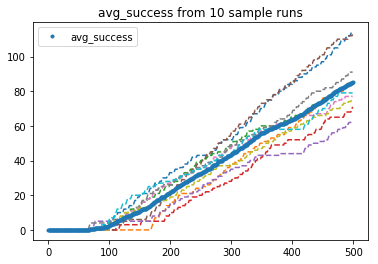

In [17]:
import time
fps = 20
visualization = False

#number of samples and steps
N=10
steps = 500

#setupvariables
model = model2
success_growths = []
first_successful_steps = []
successful_stepss = []

ax.set_title("Successful steps count")

for n in range(N):
    state = env.reset()
    successful_steps = 0
    first_successful_step = steps
    success_growth = []
    for i in range(steps):
        if visualization==True and n==0:
            time.sleep(1/fps)
            env.render()
        Q = model(Variable(torch.from_numpy(state).type(torch.FloatTensor))).detach().numpy()
        action = np.argmax(Q)
        state, reward, done, _ = env.step(action)
        running_reward += reward
        current_height = get_height(state)
        #success steps count
        if current_height>1:
            successful_steps += 1
            if first_successful_step > i:
                first_successful_step=i
        success_growth.append(successful_steps)
    success_growths.append(success_growth)
    first_successful_steps.append(first_successful_step)
    successful_stepss.append(successful_steps)
    
print('avg successful steps: {} - {:.4f}%'.format(np.mean(successful_stepss), np.mean(successful_stepss)/steps*100))
print('avg first successful step: {} '.format(np.mean(first_successful_steps)))
env.close()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
for n in range(N):
    ax.plot(success_growths[n],'--')
ax.plot(np.mean(success_growths, axis=0),'.', label="avg_success")
ax.legend()
ax.set_title("avg_success from {} sample runs".format(N))

In [18]:
#number of samples we will plot
num = 2000

#random state variables
t1 = np.random.uniform(0, 2*np.pi, num)
t2 = np.random.uniform(0, 2*np.pi, num)
Y1 = np.cos(t1)
X1 = np.sin(t1)
Y2 = np.cos(t2)
X2 = np.sin(t2)

#random angular velocity of each state
S1 = np.random.uniform(-4*np.pi, 4*np.pi, num)
S2 = np.random.uniform(-9*np.pi, 9*np.pi, num)

#Z is our action variables predicted by the model from all random variables above
Z = []
for i in range(len(t1)):
    _, action = torch.max(model2(Variable(torch.from_numpy(np.array([
        Y1[i],X1[i],Y2[i],X2[i],S1[i],S2[i]
        ]))).type(torch.FloatTensor)), dim = -1)
    Z.append(action.item())
#convert to pandas' Series object
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['-1','0','+1']

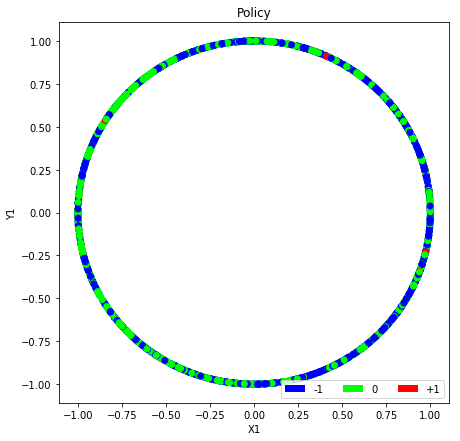

In [19]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,Y1, c=Z)
ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

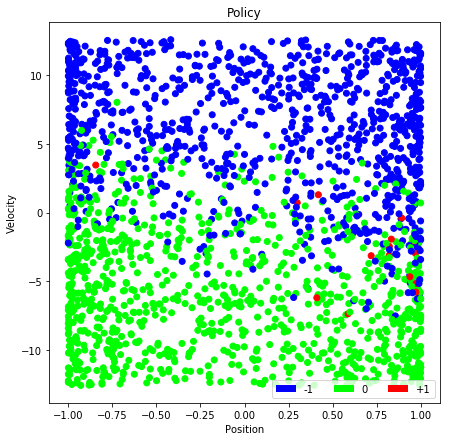

In [20]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,S1, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

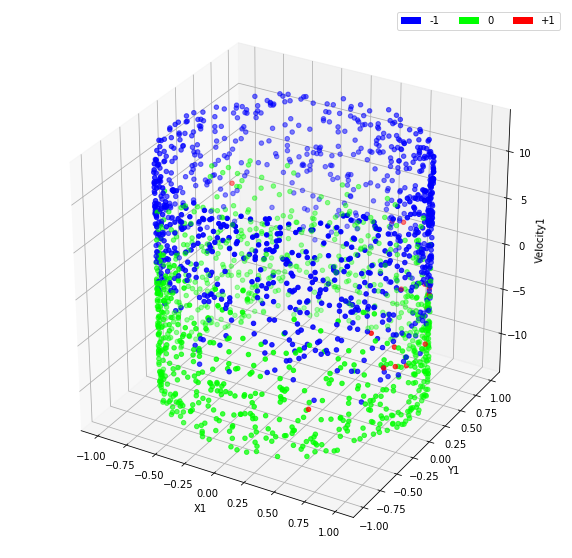

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1, Y1, S1, c=Z, marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_zlabel('Velocity1')
plt.legend(recs,labels,ncol=3)

plt.show()

### Using DDQN

Now, we will try using DDQN from HA3 to see if it will perform better than our previous models or not.

In [95]:
def eps_greedy_policy(q_values, eps):
    # YOUR CODE HERE
    m = len(q_values)
    a = np.argmax(q_values,axis=0)
    policy = np.array([eps/m]*m )
    policy[a] = policy[a] +  1 - eps

    return policy

In [104]:
class QNetwork(nn.Module):
    def __init__(self, num_states, num_actions):
        super().__init__()
        self._num_states = num_states
        self._num_actions = num_actions

#         self._fc1 = nn.Linear(self._num_states, 16, bias=False)
#         self._fc_final = nn.Linear(16, self._num_actions, bias=False)
        self._fc_final = nn.Linear(self._num_states, self._num_actions, bias=False)

        # Initialize final layer uniformly in [-1e-6, 1e-6] range, according to old Keras implementation
        nn.init.uniform_(self._fc_final.weight, a=-1e-6, b=1e-6)

    def forward(self, state):
        h=state
#         h = self._fc1(state)
#         h = self._relu1(self._fc1(state))
#         h = self._relu2(self._fc2(h))
        q_values = self._fc_final(h)
        return q_values

In [105]:
class DoubleQLearningModel(object):
    def __init__(self, device, num_states, num_actions, learning_rate):
        self._device = device
        self._num_states = num_states
        self._num_actions = num_actions
        self._lr = learning_rate

        # Define the two deep Q-networks
        self.online_model = QNetwork(self._num_states,
                                     self._num_actions).to(device=self._device)
        self.offline_model = QNetwork(
            self._num_states, self._num_actions).to(device=self._device)

        # Define optimizer. Should update online network parameters only.
        self.optimizer = torch.optim.RMSprop(self.online_model.parameters(),
                                             lr=self._lr)

        # Define loss function
        self._mse = nn.MSELoss(reduction='mean').to(device=self._device)

    def calc_loss(self, q_online_curr, q_target, a):
        '''
        Calculate loss for given batch
        :param q_online_curr: batch of q values at current state. Shape (N, num actions)
        :param q_target: batch of temporal difference targets. Shape (N,)
        :param a: batch of actions taken at current state. Shape (N,)
        :return:
        '''
        batch_size = q_online_curr.shape[0]
        assert q_online_curr.shape == (batch_size, self._num_actions)
        assert q_target.shape == (batch_size, )
        assert a.shape == (batch_size, )

        # Select only the Q-values corresponding to the actions taken (loss should only be applied for these)
        q_online_curr_allactions = q_online_curr
        q_online_curr = q_online_curr[torch.arange(batch_size),a]  # New shape: (batch_size,)
        assert q_online_curr.shape == (batch_size, )
        for j in [0, 3, 4]:
            assert q_online_curr_allactions[j, a[j]] == q_online_curr[j]

        # Make sure that gradient is not back-propagated through Q target
        assert not q_target.requires_grad

        loss = self._mse(q_online_curr, q_target)
        assert loss.shape == ()

        return loss

    def update_target_network(self):
        '''
        Update target network parameters, by copying from online network.
        '''
        online_params = self.online_model.state_dict()
        self.offline_model.load_state_dict(online_params)


In [106]:
def sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma):
    '''
    Sample mini-batch from replay buffer, and compute the mini-batch loss
    Inputs:
        ddqn          - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        replay_buffer - Replay buffer object (from which smaples will be drawn)
        batch_size    - Batch size
        gamma         - Discount factor
    Returns:
        Mini-batch loss, on which .backward() will be called to compute gradient.
    '''
    # Sample a minibatch of transitions from replay buffer
    curr_state, curr_action, reward, next_state, nonterminal = replay_buffer.sample_minibatch(batch_size)

    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input,
    # and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    # YOUR CODE HERE
    
    q_online_curr  = ddqn.online_model(curr_state)
    with torch.no_grad():
        q_online_next  = ddqn.online_model(next_state)
        q_offline_next = ddqn.offline_model(next_state)
    
    q_target = calculate_q_targets(q_online_next, q_offline_next, reward, nonterminal, gamma=gamma)
    q_target = q_target.detach()
    loss = ddqn.calc_loss(q_online_curr, q_target, curr_action)

    return loss

In [107]:
def train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 1.
    eps_end = .1 
    eps_decay = .001
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        while not finish_episode:
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1

            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            new_state, reward, finish_episode, _ = env.step(curr_action) # take one step in the evironment
            new_state = new_state[None,:]
            
            #++++++++++modified reward++++++++++++
            reward += (3/100)*(np.absolute(new_state[0][4])/(4*np.pi))
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            nonterminal_to_buffer = not finish_episode or steps == 100
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
                
        eps = max(eps - eps_decay, eps_end) # decrease epsilon        
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] > -250:
            return R_buffer, R_avg
    return R_buffer, R_avg

In [108]:
class ExperienceReplay:
    def __init__(self, device, num_states, buffer_size=1e+6):
        self._device = device
        self.__buffer = deque(maxlen=int(buffer_size))
        self._num_states = num_states

    @property
    def buffer_length(self):
        return len(self.__buffer)

    def add(self, transition):
        '''
        Adds a transition <s, a, r, s', t > to the replay buffer
        :param transition:
        :return:
        '''
        self.__buffer.append(transition)

    def sample_minibatch(self, batch_size=128):
        '''
        :param batch_size:
        :return:
        '''
        ids = np.random.choice(a=self.buffer_length, size=batch_size)
        state_batch = np.zeros([batch_size, self._num_states],
                               dtype=np.float32)
        action_batch = np.zeros([
            batch_size,
        ], dtype=np.int64)
        reward_batch = np.zeros([
            batch_size,
        ], dtype=np.float32)
        nonterminal_batch = np.zeros([
            batch_size,
        ], dtype=np.bool)
        next_state_batch = np.zeros([batch_size, self._num_states],
                                    dtype=np.float32)
        for i, index in zip(range(batch_size), ids):
            state_batch[i, :] = self.__buffer[index].s
            action_batch[i] = self.__buffer[index].a
            reward_batch[i] = self.__buffer[index].r
            nonterminal_batch[i] = self.__buffer[index].t
            next_state_batch[i, :] = self.__buffer[index].next_s

        return (
            torch.tensor(state_batch, dtype=torch.float, device=self._device),
            torch.tensor(action_batch, dtype=torch.long, device=self._device),
            torch.tensor(reward_batch, dtype=torch.float, device=self._device),
            torch.tensor(next_state_batch,
                         dtype=torch.float,
                         device=self._device),
            torch.tensor(nonterminal_batch,
                         dtype=torch.bool,
                         device=self._device),
        )



In [109]:
def calc_q_and_take_action(ddqn, state, eps):
    '''
    Calculate Q-values for current state, and take an action according to an epsilon-greedy policy.
    Inputs:
        ddqn   - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        state  - Current state. Numpy array, shape (1, num_states).
        eps    - Exploration parameter.
    Returns:
        q_online_curr   - Q(s,a) for current state s. Numpy array, shape (1, num_actions) or  (num_actions,).
        curr_action     - Selected action (0 or 1, i.e. left or right), sampled from epsilon-greedy policy. Integer.
    '''
    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input, and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    # YOUR CODE HERE
    state = torch.tensor(state, dtype=torch.float32)
    q_online_curr_torch = ddqn.online_model(state)
    q_online_curr = q_online_curr_torch[0].detach().cpu().numpy()
    policy = eps_greedy_policy(q_online_curr, eps)
    curr_action = np.random.choice( np.arange(len(q_online_curr)), p = policy)
    return q_online_curr, curr_action

In [110]:
def calculate_q_targets(q1_batch, q2_batch, r_batch, nonterminal_batch, gamma=.99):
    '''
    Calculates the Q target used for the loss
    : param q1_batch: Batch of Q(s', a) from online network. FloatTensor, shape (N, num actions)
    : param q2_batch: Batch of Q(s', a) from target network. FloatTensor, shape (N, num actions)
    : param r_batch: Batch of rewards. FloatTensor, shape (N,)
    : param nonterminal_batch: Batch of booleans, with False elements if state s' is terminal and True otherwise. BoolTensor, shape (N,)
    : param gamma: Discount factor, float.
    : return: Q target. FloatTensor, shape (N,)
    '''
    # YOUR CODE HERE
    Y =  r_batch
    online_ac = torch.argmax(q1_batch,dim=1)
    for i in range(online_ac.shape[0]):
        if nonterminal_batch[i]:
            Y[i] = r_batch[i] + gamma * q2_batch[i][online_ac[i]] 
        else:
            Y[i] = r_batch[i]

    return Y

In [111]:
device = torch.device("cpu")
# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
num_episodes = 1200
batch_size = 128
gamma = .94
learning_rate = 1e-4
enable_visualization = False
# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)


# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)

# Train
R, R_avg = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

Episode: 0, Total Reward (running avg): -498 (-498.22) Epsilon: 0.999, Avg Q: 2.155e-07
Episode: 1, Total Reward (running avg): -499 (-498.26) Epsilon: 0.998, Avg Q: 2.559e-07
Episode: 2, Total Reward (running avg): -499 (-498.27) Epsilon: 0.997, Avg Q: -0.04891
Episode: 3, Total Reward (running avg): -499 (-498.32) Epsilon: 0.996, Avg Q: -0.1517
Episode: 4, Total Reward (running avg): -498 (-498.32) Epsilon: 0.995, Avg Q: -0.1726
Episode: 5, Total Reward (running avg): -499 (-498.37) Epsilon: 0.994, Avg Q: -0.3291
Episode: 6, Total Reward (running avg): -498 (-498.36) Epsilon: 0.993, Avg Q: -0.2406
Episode: 7, Total Reward (running avg): -499 (-498.39) Epsilon: 0.992, Avg Q: -0.2857
Episode: 8, Total Reward (running avg): -498 (-498.39) Epsilon: 0.991, Avg Q: -0.4062
Episode: 9, Total Reward (running avg): -499 (-498.43) Epsilon: 0.990, Avg Q: -0.641
Episode: 10, Total Reward (running avg): -499 (-498.43) Epsilon: 0.989, Avg Q: -0.6221
Episode: 11, Total Reward (running avg): -499 (-4

Episode: 189, Total Reward (running avg): -353 (-433.38) Epsilon: 0.810, Avg Q: -5.864
Episode: 190, Total Reward (running avg): -290 (-426.21) Epsilon: 0.809, Avg Q: -6.893
Episode: 191, Total Reward (running avg): -441 (-426.94) Epsilon: 0.808, Avg Q: -7.326
Episode: 192, Total Reward (running avg): -464 (-428.81) Epsilon: 0.807, Avg Q: -6.785
Episode: 193, Total Reward (running avg): -268 (-420.76) Epsilon: 0.806, Avg Q: -5.353
Episode: 194, Total Reward (running avg): -443 (-421.87) Epsilon: 0.805, Avg Q: -7.791
Episode: 195, Total Reward (running avg): -439 (-422.72) Epsilon: 0.804, Avg Q: -4.399
Episode: 196, Total Reward (running avg): -354 (-419.27) Epsilon: 0.803, Avg Q: -5.549
Episode: 197, Total Reward (running avg): -331 (-414.83) Epsilon: 0.802, Avg Q: -5.159
Episode: 198, Total Reward (running avg): -369 (-412.53) Epsilon: 0.801, Avg Q: -6.365
Episode: 199, Total Reward (running avg): -499 (-416.84) Epsilon: 0.800, Avg Q: -8.758
Episode: 200, Total Reward (running avg): -

Episode: 377, Total Reward (running avg): -311 (-271.88) Epsilon: 0.622, Avg Q: -5.56
Episode: 378, Total Reward (running avg): -354 (-276.01) Epsilon: 0.621, Avg Q: -4.826
Episode: 379, Total Reward (running avg): -274 (-275.90) Epsilon: 0.620, Avg Q: -4.324
Episode: 380, Total Reward (running avg): -240 (-274.11) Epsilon: 0.619, Avg Q: -6.302
Episode: 381, Total Reward (running avg): -224 (-271.60) Epsilon: 0.618, Avg Q: -5.607
Episode: 382, Total Reward (running avg): -164 (-266.24) Epsilon: 0.617, Avg Q: -5.614
Episode: 383, Total Reward (running avg): -282 (-267.03) Epsilon: 0.616, Avg Q: -6.586
Episode: 384, Total Reward (running avg): -272 (-267.26) Epsilon: 0.615, Avg Q: -4.251
Episode: 385, Total Reward (running avg): -252 (-266.50) Epsilon: 0.614, Avg Q: -7.397
Episode: 386, Total Reward (running avg): -312 (-268.76) Epsilon: 0.613, Avg Q: -4.974
Episode: 387, Total Reward (running avg): -280 (-269.31) Epsilon: 0.612, Avg Q: -5.788
Episode: 388, Total Reward (running avg): -1

Try running DDQN in the environment:

avg successful steps: 85.5 - 17.1000%
avg first successful step: 84.0 


Text(0.5, 1.0, 'avg_success from 10 sample runs')

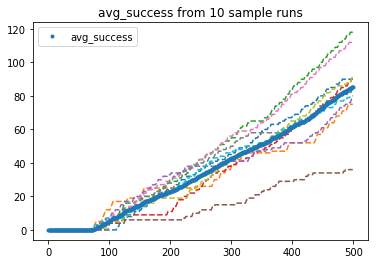

In [82]:
import time
fps = 20
visualization = False

#plot successful steps count
N=10

#setupvariables
model = ddqn
success_growths = []
first_successful_steps = []
successful_stepss = []

ax.set_title("Successful steps count")

for n in range(N):
    state = env.reset()
    steps = 500
    successful_steps = 0
    first_successful_step = steps
    success_growth = []
    for i in range(steps):
        if visualization==True and n==0:
            time.sleep(1/fps)
            env.render()
        with torch.no_grad():
            Q = model.online_model(torch.tensor(state, dtype=torch.float, device=device)).cpu().numpy()
#         Q = model(Variable(torch.from_numpy(state).type(torch.FloatTensor))).detach().numpy()
        action = np.argmax(Q)
        state, reward, done, _ = env.step(action)
        running_reward += reward
        current_height = get_height(state)
        #success steps count
        if current_height>1:
            successful_steps += 1
            if first_successful_step > i:
                first_successful_step=i
        success_growth.append(successful_steps)
    success_growths.append(success_growth)
    first_successful_steps.append(first_successful_step)
    successful_stepss.append(successful_steps)
    
print('avg successful steps: {} - {:.4f}%'.format(np.mean(successful_stepss), np.mean(successful_stepss)/steps*100))
print('avg first successful step: {} '.format(np.mean(first_successful_steps)))
env.close()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
for n in range(N):
    ax.plot(success_growths[n],'--')
ax.plot(np.mean(success_growths, axis=0),'.', label="avg_success")
ax.legend()
ax.set_title("avg_success from {} sample runs".format(N))

In [85]:
#number of samples we will plot
num = 2000
model = model.online_model

#random state variables
t1 = np.random.uniform(0, 2*np.pi, num)
t2 = np.random.uniform(0, 2*np.pi, num)
Y1 = np.cos(t1)
X1 = np.sin(t1)
Y2 = np.cos(t2)
X2 = np.sin(t2)

#random angular velocity of each state
S1 = np.random.uniform(-4*np.pi, 4*np.pi, num)
S2 = np.random.uniform(-9*np.pi, 9*np.pi, num)

#Z is our action variables predicted by the model from all random variables above
Z = []
for i in range(len(t1)):
    _, action = torch.max(model(Variable(torch.from_numpy(np.array([
        Y1[i],X1[i],Y2[i],X2[i],S1[i],S2[i]
        ]))).type(torch.FloatTensor)), dim = -1)
    Z.append(action.item())
#convert to pandas' Series object
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['-1','0','+1']

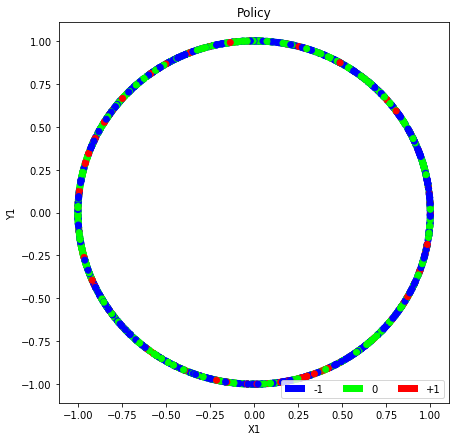

In [86]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,Y1, c=Z)
ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

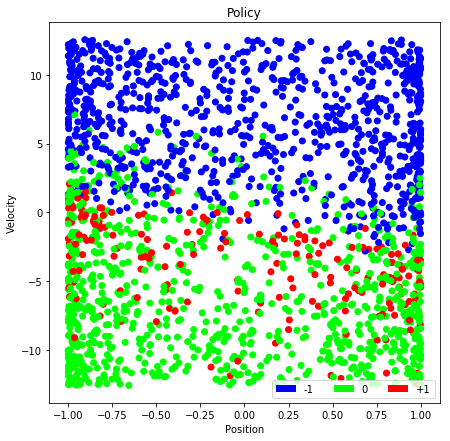

In [87]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X1,S1, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
# fig.savefig('Policy.png')
plt.show()

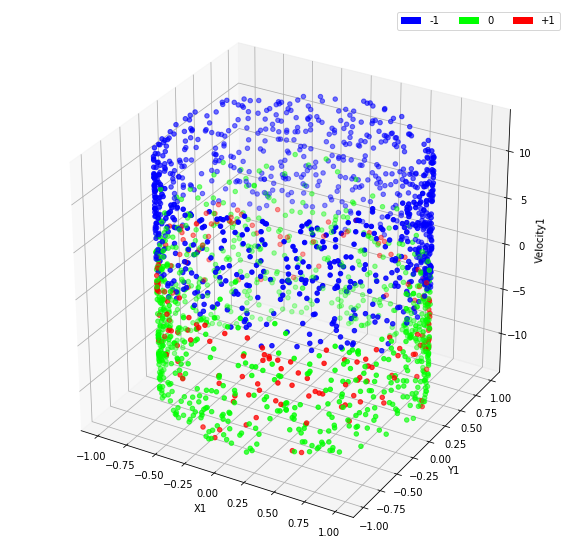

In [88]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1, Y1, S1, c=Z, marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('Y1')
ax.set_zlabel('Velocity1')
plt.legend(recs,labels,ncol=3)

plt.show()

## Dueling Deep Q-Network

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [3]:
class DuelingLinearDeepQNetwork(nn.Module):
    def __init__(self, ALPHA, n_actions, name, input_dims, chkpt_dir='tmp/dqn'):
        super(DuelingLinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_dqn')

    def forward(self, state):
        l1 = F.relu(self.fc1(state))
        l2 = F.relu(self.fc2(l1))
        V = self.V(l2)
        A = self.A(l2)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [12]:
class Agent(object):
    def __init__(self, gamma, epsilon, alpha, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.batch_size = batch_size
        self.replace_target_cnt = replace
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DuelingLinearDeepQNetwork(alpha, n_actions, input_dims=input_dims,
                                   name='q_eval', chkpt_dir=chkpt_dir)
        self.q_next = DuelingLinearDeepQNetwork(alpha, n_actions, input_dims=input_dims,
                                   name='q_next', chkpt_dir=chkpt_dir)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            observation = observation[np.newaxis,:]
            state = torch.tensor(observation).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state.float())
            action = torch.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                         if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        # using torch.Tensor seems to reset datatype to float
        # using torch.tensor preserves source data type
        state = torch.tensor(state).to(self.q_eval.device)
        new_state = torch.tensor(new_state).to(self.q_eval.device)
        action = torch.tensor(action).to(self.q_eval.device)
        rewards = torch.tensor(reward).to(self.q_eval.device)
        dones = torch.tensor(done).to(self.q_eval.device)

        V_s, A_s = self.q_eval.forward(state)
        V_s_, A_s_ = self.q_next.forward(new_state)

        q_pred = torch.add(V_s, (A_s - A_s.mean(dim=1, keepdim=True))).gather(1,
                                              action.unsqueeze(-1)).squeeze(-1)

        q_next = torch.add(V_s_, (A_s_ - A_s_.mean(dim=1, keepdim=True)))
        q_target = rewards + self.gamma*torch.max(q_next, dim=1)[0].detach()
        q_target[dones] = 0.0

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_nextorch.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_nextorch.load_checkpoint()

In [13]:
if __name__ == '__main__':
    env = gym.make('Acrobot-v1')
    episodes = 1000
    load_checkpoint = False

    agent = Agent(gamma=0.99, epsilon=1.0, alpha=5e-4,
                  input_dims=[6], n_actions=3, mem_size=100000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

    if load_checkpoint:
        agent.load_models()

    filename = 'LunarLander-Dueling-128-128-Adam-lr0005-replace100.png'
    scores = []
    eps_history = []
    n_steps = 0

    for i in range(episodes):
        done = False
        observation = env.reset()
        score = 0

        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.store_transition(observation, action,
                                    reward, observation_, int(done))
            agent.learn()

            observation = observation_


        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
#         print('episode: ', i,'Total Reward: %.1f ' % score,
#              ' average score %.1f' % avg_score,
#             'epsilon %.2f' % agent.epsilon)
        
        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}'.format(
            i, score, avg_score, agent.epsilon))
        
        
        #if i > 0 and i % 10 == 0:
        #    agent.save_models()

        eps_history.append(agent.epsilon)

episode:  0 score -500.0   average score -500.0 epsilon 0.56
episode:  1 score -500.0   average score -500.0 epsilon 0.06
episode:  2 score -121.0   average score -373.7 epsilon 0.01
episode:  3 score -104.0   average score -306.2 epsilon 0.01
episode:  4 score -92.0   average score -263.4 epsilon 0.01
episode:  5 score -254.0   average score -261.8 epsilon 0.01
episode:  6 score -268.0   average score -262.7 epsilon 0.01
episode:  7 score -119.0   average score -244.8 epsilon 0.01
episode:  8 score -142.0   average score -233.3 epsilon 0.01
episode:  9 score -122.0   average score -222.2 epsilon 0.01
episode:  10 score -140.0   average score -214.7 epsilon 0.01
episode:  11 score -148.0   average score -209.2 epsilon 0.01
episode:  12 score -151.0   average score -204.7 epsilon 0.01
episode:  13 score -142.0   average score -200.2 epsilon 0.01
episode:  14 score -168.0   average score -198.1 epsilon 0.01
episode:  15 score -151.0   average score -195.1 epsilon 0.01
episode:  16 score 

episode:  266 score -61.0   average score -88.9 epsilon 0.01
episode:  267 score -86.0   average score -89.0 epsilon 0.01
episode:  268 score -93.0   average score -89.0 epsilon 0.01
episode:  269 score -121.0   average score -89.6 epsilon 0.01
episode:  270 score -99.0   average score -89.8 epsilon 0.01
episode:  271 score -105.0   average score -89.7 epsilon 0.01
episode:  272 score -70.0   average score -89.0 epsilon 0.01
episode:  273 score -101.0   average score -89.2 epsilon 0.01
episode:  274 score -74.0   average score -89.2 epsilon 0.01
episode:  275 score -127.0   average score -89.4 epsilon 0.01
episode:  276 score -88.0   average score -89.3 epsilon 0.01
episode:  277 score -89.0   average score -88.7 epsilon 0.01
episode:  278 score -156.0   average score -89.3 epsilon 0.01
episode:  279 score -96.0   average score -89.4 epsilon 0.01
episode:  280 score -101.0   average score -89.6 epsilon 0.01
episode:  281 score -110.0   average score -90.0 epsilon 0.01
episode:  282 sco

episode:  532 score -83.0   average score -88.2 epsilon 0.01
episode:  533 score -101.0   average score -88.0 epsilon 0.01
episode:  534 score -84.0   average score -88.1 epsilon 0.01
episode:  535 score -101.0   average score -88.5 epsilon 0.01
episode:  536 score -97.0   average score -88.7 epsilon 0.01
episode:  537 score -76.0   average score -88.3 epsilon 0.01
episode:  538 score -76.0   average score -88.2 epsilon 0.01
episode:  539 score -71.0   average score -88.1 epsilon 0.01
episode:  540 score -70.0   average score -88.0 epsilon 0.01
episode:  541 score -92.0   average score -88.0 epsilon 0.01
episode:  542 score -73.0   average score -87.9 epsilon 0.01
episode:  543 score -62.0   average score -87.7 epsilon 0.01
episode:  544 score -79.0   average score -87.5 epsilon 0.01
episode:  545 score -77.0   average score -87.5 epsilon 0.01
episode:  546 score -105.0   average score -87.8 epsilon 0.01
episode:  547 score -63.0   average score -87.2 epsilon 0.01
episode:  548 score -

episode:  798 score -78.0   average score -85.6 epsilon 0.01
episode:  799 score -81.0   average score -85.3 epsilon 0.01
episode:  800 score -77.0   average score -85.0 epsilon 0.01
episode:  801 score -80.0   average score -85.0 epsilon 0.01
episode:  802 score -68.0   average score -84.9 epsilon 0.01
episode:  803 score -122.0   average score -85.5 epsilon 0.01
episode:  804 score -78.0   average score -85.4 epsilon 0.01
episode:  805 score -97.0   average score -85.3 epsilon 0.01
episode:  806 score -101.0   average score -85.3 epsilon 0.01
episode:  807 score -84.0   average score -85.4 epsilon 0.01
episode:  808 score -112.0   average score -85.6 epsilon 0.01
episode:  809 score -106.0   average score -85.9 epsilon 0.01
episode:  810 score -72.0   average score -85.8 epsilon 0.01
episode:  811 score -73.0   average score -85.7 epsilon 0.01
episode:  812 score -74.0   average score -85.7 epsilon 0.01
episode:  813 score -90.0   average score -85.8 epsilon 0.01
episode:  814 score 

NameError: name 'plot_learning_curve' is not defined

In [19]:

    x = [i+1 for i in range(episodes)]
    plotlearning(x, scores, eps_history, filename)

[-500.0,
 -500.0,
 -121.0,
 -104.0,
 -92.0,
 -254.0,
 -268.0,
 -119.0,
 -142.0,
 -122.0,
 -140.0,
 -148.0,
 -151.0,
 -142.0,
 -168.0,
 -151.0,
 -124.0,
 -107.0,
 -123.0,
 -240.0,
 -111.0,
 -106.0,
 -118.0,
 -175.0,
 -114.0,
 -131.0,
 -145.0,
 -126.0,
 -179.0,
 -111.0,
 -108.0,
 -152.0,
 -117.0,
 -136.0,
 -125.0,
 -102.0,
 -108.0,
 -139.0,
 -196.0,
 -103.0,
 -154.0,
 -106.0,
 -109.0,
 -171.0,
 -89.0,
 -128.0,
 -143.0,
 -89.0,
 -82.0,
 -178.0,
 -102.0,
 -82.0,
 -134.0,
 -94.0,
 -76.0,
 -91.0,
 -85.0,
 -97.0,
 -77.0,
 -73.0,
 -69.0,
 -89.0,
 -91.0,
 -86.0,
 -130.0,
 -87.0,
 -92.0,
 -83.0,
 -98.0,
 -93.0,
 -89.0,
 -99.0,
 -96.0,
 -72.0,
 -73.0,
 -90.0,
 -76.0,
 -93.0,
 -114.0,
 -77.0,
 -90.0,
 -104.0,
 -86.0,
 -103.0,
 -89.0,
 -75.0,
 -99.0,
 -78.0,
 -84.0,
 -109.0,
 -84.0,
 -77.0,
 -73.0,
 -108.0,
 -85.0,
 -78.0,
 -80.0,
 -76.0,
 -99.0,
 -98.0,
 -64.0,
 -76.0,
 -103.0,
 -85.0,
 -123.0,
 -86.0,
 -90.0,
 -98.0,
 -71.0,
 -91.0,
 -136.0,
 -86.0,
 -71.0,
 -148.0,
 -97.0,
 -61.0,
 -69.0,
 -95.0